In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

Załóżmy, że badamy działanie innowacyjnego leku na obniżenie ciśnienia na 3 grupach osób:

 - 1 - w wieku 51-60 lat
 - 2 - w wieku 61-70 lat
 - 3 - w wieku 71 i więcej lat
 
Chcemy sprawdzić, czy w każdej grupie wiekowej lek obniża ciśnienie do tego samego poziomu, a jeżeli nie, to w której grupie lek ma inne działanie niż w pozostałych.

In [2]:
data = np.loadtxt('post_hoc.txt')
data = pd.DataFrame({'Feature':data[:,0],'Group':data[:,1]})
group1 = data[data['Group']==1]['Feature']
group2 = data[data['Group']==2]['Feature']
group3 = data[data['Group']==3]['Feature']

Wizualizacja danych

Text(0, 0.5, 'Feature')

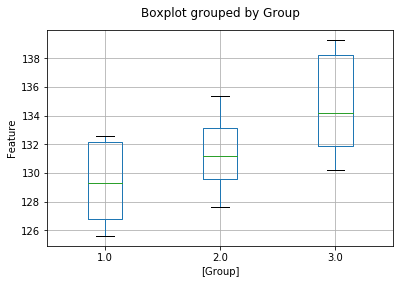

In [3]:
data.boxplot(by='Group')
plt.title('')
plt.ylabel('Feature')

# Sprawdzamy czy wariancja jest jednakowa przy pomocy testu Levene

In [4]:
(W,p) = stats.levene(group1, group2, group3)
print(p)
if p<0.05:
    print(('Warning: the p-value of the Levene test is <0.05: p={0}'.format(p)))

0.2871077959473117


# Wykonujemy jednoczynnikową analizę wariancji

In [5]:
f, p = stats.f_oneway(group1,group2,group3)
print(f)
print(p)

8.561309129772445
0.0013197254531356934


# Wyliczenie $SS_{Error}$ i $SS_{Treatment}$

In [6]:
groups = data.groupby('Group')
(ss_treatments, ss_error) = (0, 0)
for val, group in groups:
    ss_error += sum((group['Feature'] - group['Feature'].mean())**2)
    ss_treatments += len(group) * (group['Feature'].mean() - data['Feature'].mean())**2
print(ss_treatments)
print(ss_error)

159.02599999999978
250.76200000000023


# Wyliczenie stopni swobody

In [7]:
df_groups = len(groups)-1
df_residuals = len(data)-len(groups)

# Wyliczenie wartości statystki testowej i p-value

In [8]:
F = (ss_treatments/df_groups) / (ss_error/df_residuals)
df = stats.f(df_groups,df_residuals)
p = df.sf(F)
print(('ANOVA-Results: F = {0}, and p={1}'.format(F, p)))

ANOVA-Results: F = 8.561309129772434, and p=0.001319725453135703


# Analiza post hoc
Wiedząc, że średnie w grupach nie są równe, chcemy sprawdzić dokładnie pomiędzy którymi grupami występuje różnica w średnich.

In [9]:
multiComp = MultiComparison(data['Feature'], data['Group'])

In [10]:
print((multiComp.tukeyhsd().summary()))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0     2.02 0.3155 -1.3586 5.3986  False
   1.0    3.0     5.57  0.001  2.1914 8.9486   True
   2.0    3.0     3.55  0.038  0.1714 6.9286   True
---------------------------------------------------


# Wizualizacja wyniku

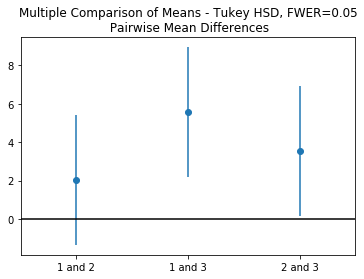

In [11]:
# Get the data
xvals = np.arange(3)
res2 = pairwise_tukeyhsd(data['Feature'], data['Group'])
errors = np.ravel(np.diff(res2.confint)/2)

# Plot them
plt.errorbar(xvals, res2.meandiffs, yerr=errors, fmt='o')

# Put on labels
pair_labels = multiComp.groupsunique[np.column_stack(res2._multicomp.pairindices)]
labels = []
for i in range(len(pair_labels)):
    labels.append(str(int(pair_labels[i][0]))+' and '+str(int(pair_labels[i][1])))
plt.xticks(xvals, labels)

# Format the plot
xlim = -0.5, 2.5
plt.hlines(0, *xlim)
plt.xlim(*xlim)
plt.title('Multiple Comparison of Means - Tukey HSD, FWER=0.05' + '\n Pairwise Mean Differences')          
plt.show()